In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, run_pheno_correlations, get_fdr_p_df, get_sys_prop, run_ttest, get_cohend, create_dummy_vars

In [4]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                                        parc_str = parc_str, parc_scale = parc_scale)

In [5]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs


## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']
metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']

## Load data

In [8]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '6_results_correlations', 'out', outfile_prefix+'df.csv')); df.set_index(['bblid', 'scanid'], inplace = True)
df_z = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '6_results_correlations', 'out', outfile_prefix+'df_z.csv')); df_z.set_index(['bblid', 'scanid'], inplace = True)
df_pheno_z = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '6_results_correlations', 'out', outfile_prefix+'df_pheno_z.csv')); df_pheno_z.set_index(['pheno', 'variable'], inplace = True)
region_filter = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '6_results_correlations', 'out', outfile_prefix+'region_filter.csv'), index_col=0); region_filter = region_filter.iloc[:,0].astype(bool)

# Group analysis

## Create grouping variable

In [9]:
groups = ('goassessSmryDep', 'goassessSmryAdd')
# groups = ('goassessSmryMood','goassessSmryPsy')
# groups = ('goassessSmryDep','goassessSmryPsy')

group_idx = create_dummy_vars(df.loc[df.loc[:,train_test_str] == 1,:], groups, filter_comorbid = True)

goassessSmryDep: 192
goassessSmryAdd: 229
Comorbid N: 48
goassessSmryDep: 144
goassessSmryAdd: 181


In [10]:
# pad with zeros to match dimensions with training set
zero_pad = np.zeros((np.sum(df[train_test_str] == 0),group_idx.shape[1])).astype(bool)
group_idx = np.append(zero_pad, group_idx, axis = 0); print(group_idx.shape)

(1393, 2)


### Demographics

In [11]:
print(groups[0],
      'mean age:', df.loc[group_idx[:,0],'ageAtScan1_Years'].mean().round(2),
      '(', df.loc[group_idx[:,0],'ageAtScan1_Years'].std().round(2), ')')

goassessSmryDep mean age: 17.62 ( 2.28 )


In [12]:
df.loc[group_idx[:,0],'sex_adj'].value_counts() / np.sum(group_idx[:,0]) * 100

1    67.361111
0    32.638889
Name: sex_adj, dtype: float64

In [13]:
print(groups[1],
      'mean age:', df.loc[group_idx[:,1],'ageAtScan1_Years'].mean().round(2),
      '(', df.loc[group_idx[:,1],'ageAtScan1_Years'].std().round(2), ')')

goassessSmryAdd mean age: 13.62 ( 3.1 )


In [14]:
df.loc[group_idx[:,1],'sex_adj'].value_counts() / np.sum(group_idx[:,1]) * 100

0    62.430939
1    37.569061
Name: sex_adj, dtype: float64

In [15]:
sp.stats.ttest_ind(df.loc[group_idx[:,0],'ageAtScan1_Years'], df.loc[group_idx[:,1],'ageAtScan1_Years'])

Ttest_indResult(statistic=12.96507810159401, pvalue=3.093893726364799e-31)

In [16]:
# get pheno correlations without subjects in the diagnostic groups
# note, these correlations are generated prior to regressing out age/sex below to keep them in line with what was done in the primary analyses (results_s2_phenos)
# note, in the primary analyses i found that controlling for age/sex in the z scores made no difference to the results which is why it's not included
# df_pheno_z_woutgroups = run_pheno_correlations(df.loc[group_idx.sum(axis = 1) == 0,phenos], df_z.loc[group_idx.sum(axis = 1) == 0,:], method = method, assign_p = 'parametric')

In [17]:
# df_pheno_z_woutgroups.head()

### Regress age/sex out of node features

In [18]:
# Given differences in demographics between groups, we regress age/sex from z scores before calculating cohen's D
df_nuis = df.loc[:,['ageAtScan1_Years','sex_adj']]
df_nuis = sm.add_constant(df_nuis)

# df_z
cols = df_z.columns
mdl = sm.OLS(df_z.loc[:,cols], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_z_regr = df_z.loc[:,cols] - y_pred

# df_z_regr = df_z.copy()

## Disorder groups vs. HCs

In [19]:
for i, group in enumerate(groups):
    i_idx = group_idx[:,i]
    for metric in metrics:
        df_y = df_z_regr.loc[df[train_test_str] == 0,region_filter].filter(regex = metric, axis = 1)
        df_x = df_z_regr.loc[i_idx,region_filter].filter(regex = metric, axis = 1)
        df_out = run_ttest(df_x, df_y, tail = 'one')
        print(group+'_'+metric + ', significant t-tests:', (np.sum(df_out.loc[:,'p-corr'] < .05) / df_out.shape[0] * 100))

goassessSmryDep_ct, significant t-tests: 1.1173184357541899
goassessSmryDep_vol, significant t-tests: 2.056555269922879
goassessSmryAdd_ct, significant t-tests: 0.27932960893854747
goassessSmryAdd_vol, significant t-tests: 1.0282776349614395


In [20]:
metric = metrics[1]; print(metric)

vol


### Spatial correlations

In [21]:
df_y = df_z_regr.loc[df[train_test_str] == 0,:].filter(regex = metric, axis = 1)

X = get_cohend(df_z_regr.loc[group_idx[:,0],:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('Depression')
y = get_cohend(df_z_regr.loc[group_idx[:,1],:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('ADHD')
df_input = pd.concat((X, y), axis = 1)

df_input.head()

,Depression,ADHD
vol_0,-0.100558,-0.120348
vol_1,-0.166959,-0.205082
vol_2,-0.164505,-0.037587
vol_3,-0.170553,-0.175234
vol_4,-0.110595,-0.168217


(0.40118506333550774, 6.710117764114861e-17)


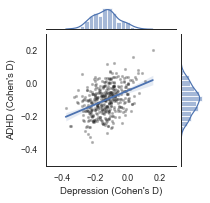

In [22]:
print(sp.stats.pearsonr(x = df_input.loc[:,'Depression'], y = df_input.loc[:,'ADHD']))

sns.set(style='white', context = 'paper', font_scale = 1)
f = sns.jointplot(x = df_input.loc[:,'Depression'], y = df_input.loc[:,'ADHD'], kind="reg")
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.set_axis_labels('Depression (Cohen\'s D)', 'ADHD (Cohen\'s D)')
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_ylim([-0.5, 0.3])
f.ax_joint.set_xlim([-0.5, 0.3])
f.savefig(outfile_prefix+'cohensd_spatial_corr_depression->adhd.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Regress p out of node features

In [23]:
corr_diff = np.zeros(len(phenos))

In [24]:
for pheno in phenos:
    df_nuis = df.loc[:,['ageAtScan1_Years','sex_adj',pheno]]
#     df_nuis = df.loc[:,pheno]
    df_nuis = sm.add_constant(df_nuis)

    # df_z
    cols = df_z.columns
    mdl = sm.OLS(df_z.loc[:,cols], df_nuis).fit()
    y_pred = mdl.predict(df_nuis)
    y_pred.columns = cols
    df_z_regr = df_z.loc[:,cols] - y_pred

    df_y = df_z_regr.loc[df[train_test_str] == 0,:].filter(regex = metric, axis = 1)

    X = get_cohend(df_z_regr.loc[group_idx[:,0],:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('Depression')
    y = get_cohend(df_z_regr.loc[group_idx[:,1],:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('ADHD')
    df_input_p = pd.concat((df_pheno_z.loc[pheno,'coef'].filter(regex = metric).astype(float), X, y), axis = 1)
    
    print(pheno, np.round(sp.stats.pearsonr(X,y),2))

Overall_Psychopathology [0.18 0.  ]
Psychosis_Positive [0.38 0.  ]
Psychosis_NegativeDisorg [0.38 0.  ]
AnxiousMisery [0.42 0.  ]
Externalizing [0.38 0.  ]
Fear [0.39 0.  ]


In [25]:
p = 0
pheno = phenos[p]; print(pheno)

Overall_Psychopathology


In [26]:
# Given differences in demographics between groups, we regress age/sex from z scores before calculating cohen's D
df_nuis = df.loc[:,['ageAtScan1_Years','sex_adj',pheno]]
# df_nuis = df.loc[:,pheno]
df_nuis = sm.add_constant(df_nuis)

# df_z
cols = df_z.columns
mdl = sm.OLS(df_z.loc[:,cols], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_z_regr = df_z.loc[:,cols] - y_pred

In [27]:
df_y = df_z_regr.loc[df[train_test_str] == 0,:].filter(regex = metric, axis = 1)

X = get_cohend(df_z_regr.loc[group_idx[:,0],:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('Depression')
y = get_cohend(df_z_regr.loc[group_idx[:,1],:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('ADHD')
df_input_p = pd.concat((df_pheno_z.loc[pheno,'coef'].filter(regex = metric).astype(float), X, y), axis = 1)

df_input_p.head()

,coef,Depression,ADHD
variable,,,
vol_0,-0.063224,-0.024033,-0.068792
vol_1,-0.054480,-0.083225,-0.147424
vol_2,-0.078740,-0.047285,0.040674
vol_3,-0.079932,-0.055193,-0.097419
vol_4,-0.067774,0.012343,-0.084962


(0.18269471848432783, 0.00023932364717762377)


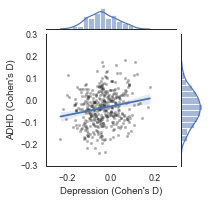

In [28]:
print(sp.stats.pearsonr(x = df_input_p.loc[:,'Depression'], y = df_input_p.loc[:,'ADHD']))

sns.set(style='white', context = 'paper', font_scale = 1)
f = sns.jointplot(x = df_input_p.loc[:,'Depression'], y = df_input_p.loc[:,'ADHD'], kind="reg")
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.set_axis_labels('Depression (Cohen\'s D)', 'ADHD (Cohen\'s D)')
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_ylim([-0.3, 0.3])
f.ax_joint.set_xlim([-0.3, 0.3])
f.savefig(outfile_prefix+'cohensd_spatial_corr_depression->adhd_p_nuis.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

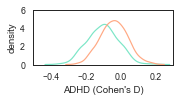

In [29]:
f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(1)
sns.kdeplot(df_input.loc[:,'ADHD'], ax = ax, color = cmap[0], label = 'no p')
sns.kdeplot(df_input_p.loc[:,'ADHD'], ax = ax, color = cmap[1], label = 'p')
ax.legend().remove()
ax.set_ylim([0, 6])
ax.set_xlim([-0.5, 0.3])
ax.set_xlabel('ADHD (Cohen\'s D)')
ax.set_ylabel('density')
f.savefig(outfile_prefix+'cohensd_adhd.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [30]:
sp.stats.ttest_rel(df_input_p.loc[:,'ADHD'],df_input.loc[:,'ADHD'])

Ttest_relResult(statistic=40.22322842096655, pvalue=1.8113170187944847e-142)

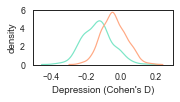

In [31]:
f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(1)
sns.kdeplot(df_input.loc[:,'Depression'], ax = ax, color = cmap[0], label = 'no p')
sns.kdeplot(df_input_p.loc[:,'Depression'], ax = ax, color = cmap[1], label = 'p')
ax.legend().remove()
ax.set_ylim([0, 6])
ax.set_xlim([-0.5, 0.3])
ax.set_xlabel('Depression (Cohen\'s D)')
ax.set_ylabel('density')
f.savefig(outfile_prefix+'cohensd_depression.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [32]:
sp.stats.ttest_rel(df_input_p.loc[:,'Depression'],df_input.loc[:,'Depression'])

Ttest_relResult(statistic=40.28125057939787, pvalue=1.1414219049027529e-142)